Refer to autodistill_test_Multi_Item.ipynb for more information on the auto labeling. This notebook is just a testing of the autolabeled data from the grounded-SAM model (The results are very bad due to the labeled data consisting of many bounding boxes for singular items). We did learn, however, that the model can track the shapes of the produce, it's just that since the training data was dirty (many bounding boxes, most likely many classes per item) the model is detecting multiple classes per item detected.

We then decided to manually label our collected data using roboflow (Results of manually labeled data first iteration are in the Yolov8_roboflow_dataset_finetune_v1.ipynb notebook).

In [ ]:
!pip install ultralytics
!pip install supervision==0.24.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 974.8/974.8 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 96.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninsta

Copy files from autolabeled dataset (images, labels, data.yaml), create train, test, split, and reformat dataset to structure:
- Dataset
     - train
        - images
        - labels
     - valid
        - images
        - labels
     - test
        - images
        - labels
     - data.yaml



In [ ]:
import os
import shutil
import random
import yaml
from tqdm import tqdm

# Load dataset from drive
flat_dataset_dir = '/content/drive/MyDrive/Walmart_AI_Project/autolabeled_dataset'
output_structured_dir = '/content/autolabeled_split_dataset'

# List of class names (Order matters)
class_names = ['TOMATOES', 'LIMES', 'BELL_PEPPER', 'APPLES', 'ORANGE_PEPPER', 'AVOCADOS', 'LEMONS']
image_extension = ".png"

# Split ratios
TRAIN_RATIO = 0.8
VALID_RATIO = 0.1
TEST_RATIO = 0.1

# Define paths
flat_images_dir = os.path.join(flat_dataset_dir, 'images')
flat_labels_dir = os.path.join(flat_dataset_dir, 'labels')

train_img_dir = os.path.join(output_structured_dir, 'train', 'images')
train_lbl_dir = os.path.join(output_structured_dir, 'train', 'labels')
valid_img_dir = os.path.join(output_structured_dir, 'valid', 'images')
valid_lbl_dir = os.path.join(output_structured_dir, 'valid', 'labels')
test_img_dir = os.path.join(output_structured_dir, 'test', 'images')
test_lbl_dir = os.path.join(output_structured_dir, 'test', 'labels')
final_data_yaml_path = os.path.join(output_structured_dir, "data.yaml")

if not os.path.exists(flat_images_dir):
    print(f"Error: Flat image directory not found: {flat_images_dir}")
    exit()
if not os.path.exists(flat_labels_dir):
    print(f"Error: Flat label directory not found: {flat_labels_dir}")
    exit()

# Get list of files
print("Listing files...")
all_image_files = [f for f in os.listdir(flat_images_dir) if f.lower().endswith(image_extension)]
valid_files = []

for img_file in all_image_files:
    basename = os.path.splitext(img_file)[0]
    label_file = basename + ".txt"
    if os.path.exists(os.path.join(flat_labels_dir, label_file)):
        valid_files.append(basename)
    else:
        print(f"Warning: Label file '{label_file}' not found for image '{img_file}'. Skipping.")

if not valid_files:
    print("Error: No valid image/label pairs found.")
    exit()

print(f"Found {len(valid_files)} valid image/label pairs.")

# Shuffle and split
print("Shuffling and calculating splits...")
random.seed(42)
random.shuffle(valid_files)

total_count = len(valid_files)
train_count = int(total_count * TRAIN_RATIO)
valid_count = int(total_count * VALID_RATIO)
test_count = total_count - train_count - valid_count

# Calculate indices for slicing
idx_train_end = train_count
idx_valid_end = train_count + valid_count

# Get the lists of basenames for each split
train_files = valid_files[:idx_train_end]
valid_files_split = valid_files[idx_train_end:idx_valid_end]
test_files = valid_files[idx_valid_end:] # The rest are test files

print(f"Split sizes: Train({len(train_files)}), Valid({len(valid_files_split)}), Test({len(test_files)})")

# Create Output Directories
print("Creating output directories...")
os.makedirs(train_img_dir, exist_ok=True)
os.makedirs(train_lbl_dir, exist_ok=True)
os.makedirs(valid_img_dir, exist_ok=True)
os.makedirs(valid_lbl_dir, exist_ok=True)
os.makedirs(test_img_dir, exist_ok=True)
os.makedirs(test_lbl_dir, exist_ok=True)

def copy_files(basenames, source_img_dir, source_lbl_dir, dest_img_dir, dest_lbl_dir, img_ext):
    '''
    Copies img and label files to destination directory while incorporating the basenames for easier dynamic file naming.

    Args:
        sbasenames (str): Name of the file before extension.
        source_img_dir (str): Path to the image source directory.
        source_lbl_dir (str): Path to the label source directory.
        dest_img_dir (str): Path to the image destination directory.
        dest_lbl_dir (str): Path to the label destination directory.
        img_ext (str): Image file extension.
    Returns:
        int: Number of copied files.
    '''
    copied_count = 0
    for basename in tqdm(basenames, desc=f"Copying to {os.path.basename(os.path.dirname(dest_img_dir))}"):
        # Copy image file name for label file name
        img_filename = basename + img_ext
        lbl_filename = basename + ".txt"

        source_img = os.path.join(source_img_dir, img_filename)
        source_lbl = os.path.join(source_lbl_dir, lbl_filename)

        dest_img = os.path.join(dest_img_dir, img_filename)
        dest_lbl = os.path.join(dest_lbl_dir, lbl_filename)

        try:
            shutil.copy2(source_img, dest_img)
            shutil.copy2(source_lbl, dest_lbl)
            copied_count += 1
        except Exception as e:
            print(f"\nError copying {basename}: {e}")
    return copied_count

# Copy files
print("Copying files to split directories...")
copy_files(train_files, flat_images_dir, flat_labels_dir, train_img_dir, train_lbl_dir, image_extension)
copy_files(valid_files_split, flat_images_dir, flat_labels_dir, valid_img_dir, valid_lbl_dir, image_extension)
copy_files(test_files, flat_images_dir, flat_labels_dir, test_img_dir, test_lbl_dir, image_extension)

# Create final data.yaml
print(f"Creating final data.yaml at {final_data_yaml_path}...")
final_yaml_content = {
    'train': os.path.abspath(train_img_dir),
    'val': os.path.abspath(valid_img_dir),
    'test': os.path.abspath(test_img_dir) if test_files else '',
    'nc': len(class_names),
    'names': class_names
}

with open(final_data_yaml_path, 'w') as f:
    yaml.dump(final_yaml_content, f, sort_keys=False)
print(f"\nDataset successfully split and saved to: {output_structured_dir}")

Listing files...
Found 320 valid image/label pairs.
Shuffling and calculating splits...
Split sizes: Train(256), Valid(32), Test(32)
Creating output directories...
Copying files to split directories...


Copying to test: 100%|██████████| 32/32 [00:08<00:00,  3.58it/s]

Creating final data.yaml at /content/autolabeled_split_dataset/data.yaml...

Dataset successfully split and saved to: /content/autolabeled_split_dataset


Run baseline inference test on testing set with un-finetuned model.

In [ ]:
# Load test images
test_images = "/content/autolabeled_split_dataset/test/images"
# Evaluate on test images
!yolo predict \
  model=yolov8n.pt \
  source="{test_images}" \
  save=True \
  device=0 \
  name="autolabeled_yolov8n_pre-trained_predictions"
  # conf=0.4 # Conf threshold

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
100% 6.25M/6.25M [00:00<00:00, 110MB/s]
Ultralytics 8.3.109 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs

image 1/32 /content/autolabeled_split_dataset/test/images/APPLES_MD_16.png: 480x640 1 suitcase, 61.8ms
image 2/32 /content/autolabeled_split_dataset/test/images/APPLES_MD_22.png: 480x640 1 person, 7.6ms
image 3/32 /content/autolabeled_split_dataset/test/images/AVOCADO_SCALE_EZ_1.png: 480x640 1 person, 1 laptop, 7.5ms
image 4/32 /content/autolabeled_split_dataset/test/images/AVOCADO_SCALE_HD_1.png: 480x640 1 person, 8.0ms
image 5/32 /content/autolabeled_split_dataset/test/images

In [ ]:
from IPython.display import Image, display
import os
test_img_run = "/content/runs/detect/autolabeled_yolov8n_pre-trained_predictions"
tested_images = [f for f in os.listdir(test_img_run)]
count = 0
for img in tested_images:
  count += 1
  display(Image(filename=os.path.join(test_img_run, img)))
  if count > 10:
    break

Finetune yolov8 nano on groundedSAM autolabeled dataset.

In [ ]:
# Train
!yolo train \
  data="/content/autolabeled_split_dataset/data.yaml" \
  model=yolov8n.pt \
  epochs=50 \
  batch=64 \
  workers=4 \
  imgsz=640 \
  device=0 \
  name="autolabeled_yolov8n_train"

Ultralytics 8.3.109 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/autolabeled_split_dataset/data.yaml, epochs=50, time=None, patience=100, batch=64, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=4, project=None, name=autolabeled_yolov8n_train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_con

Evaluate finetuned yolov8 nano on test images.

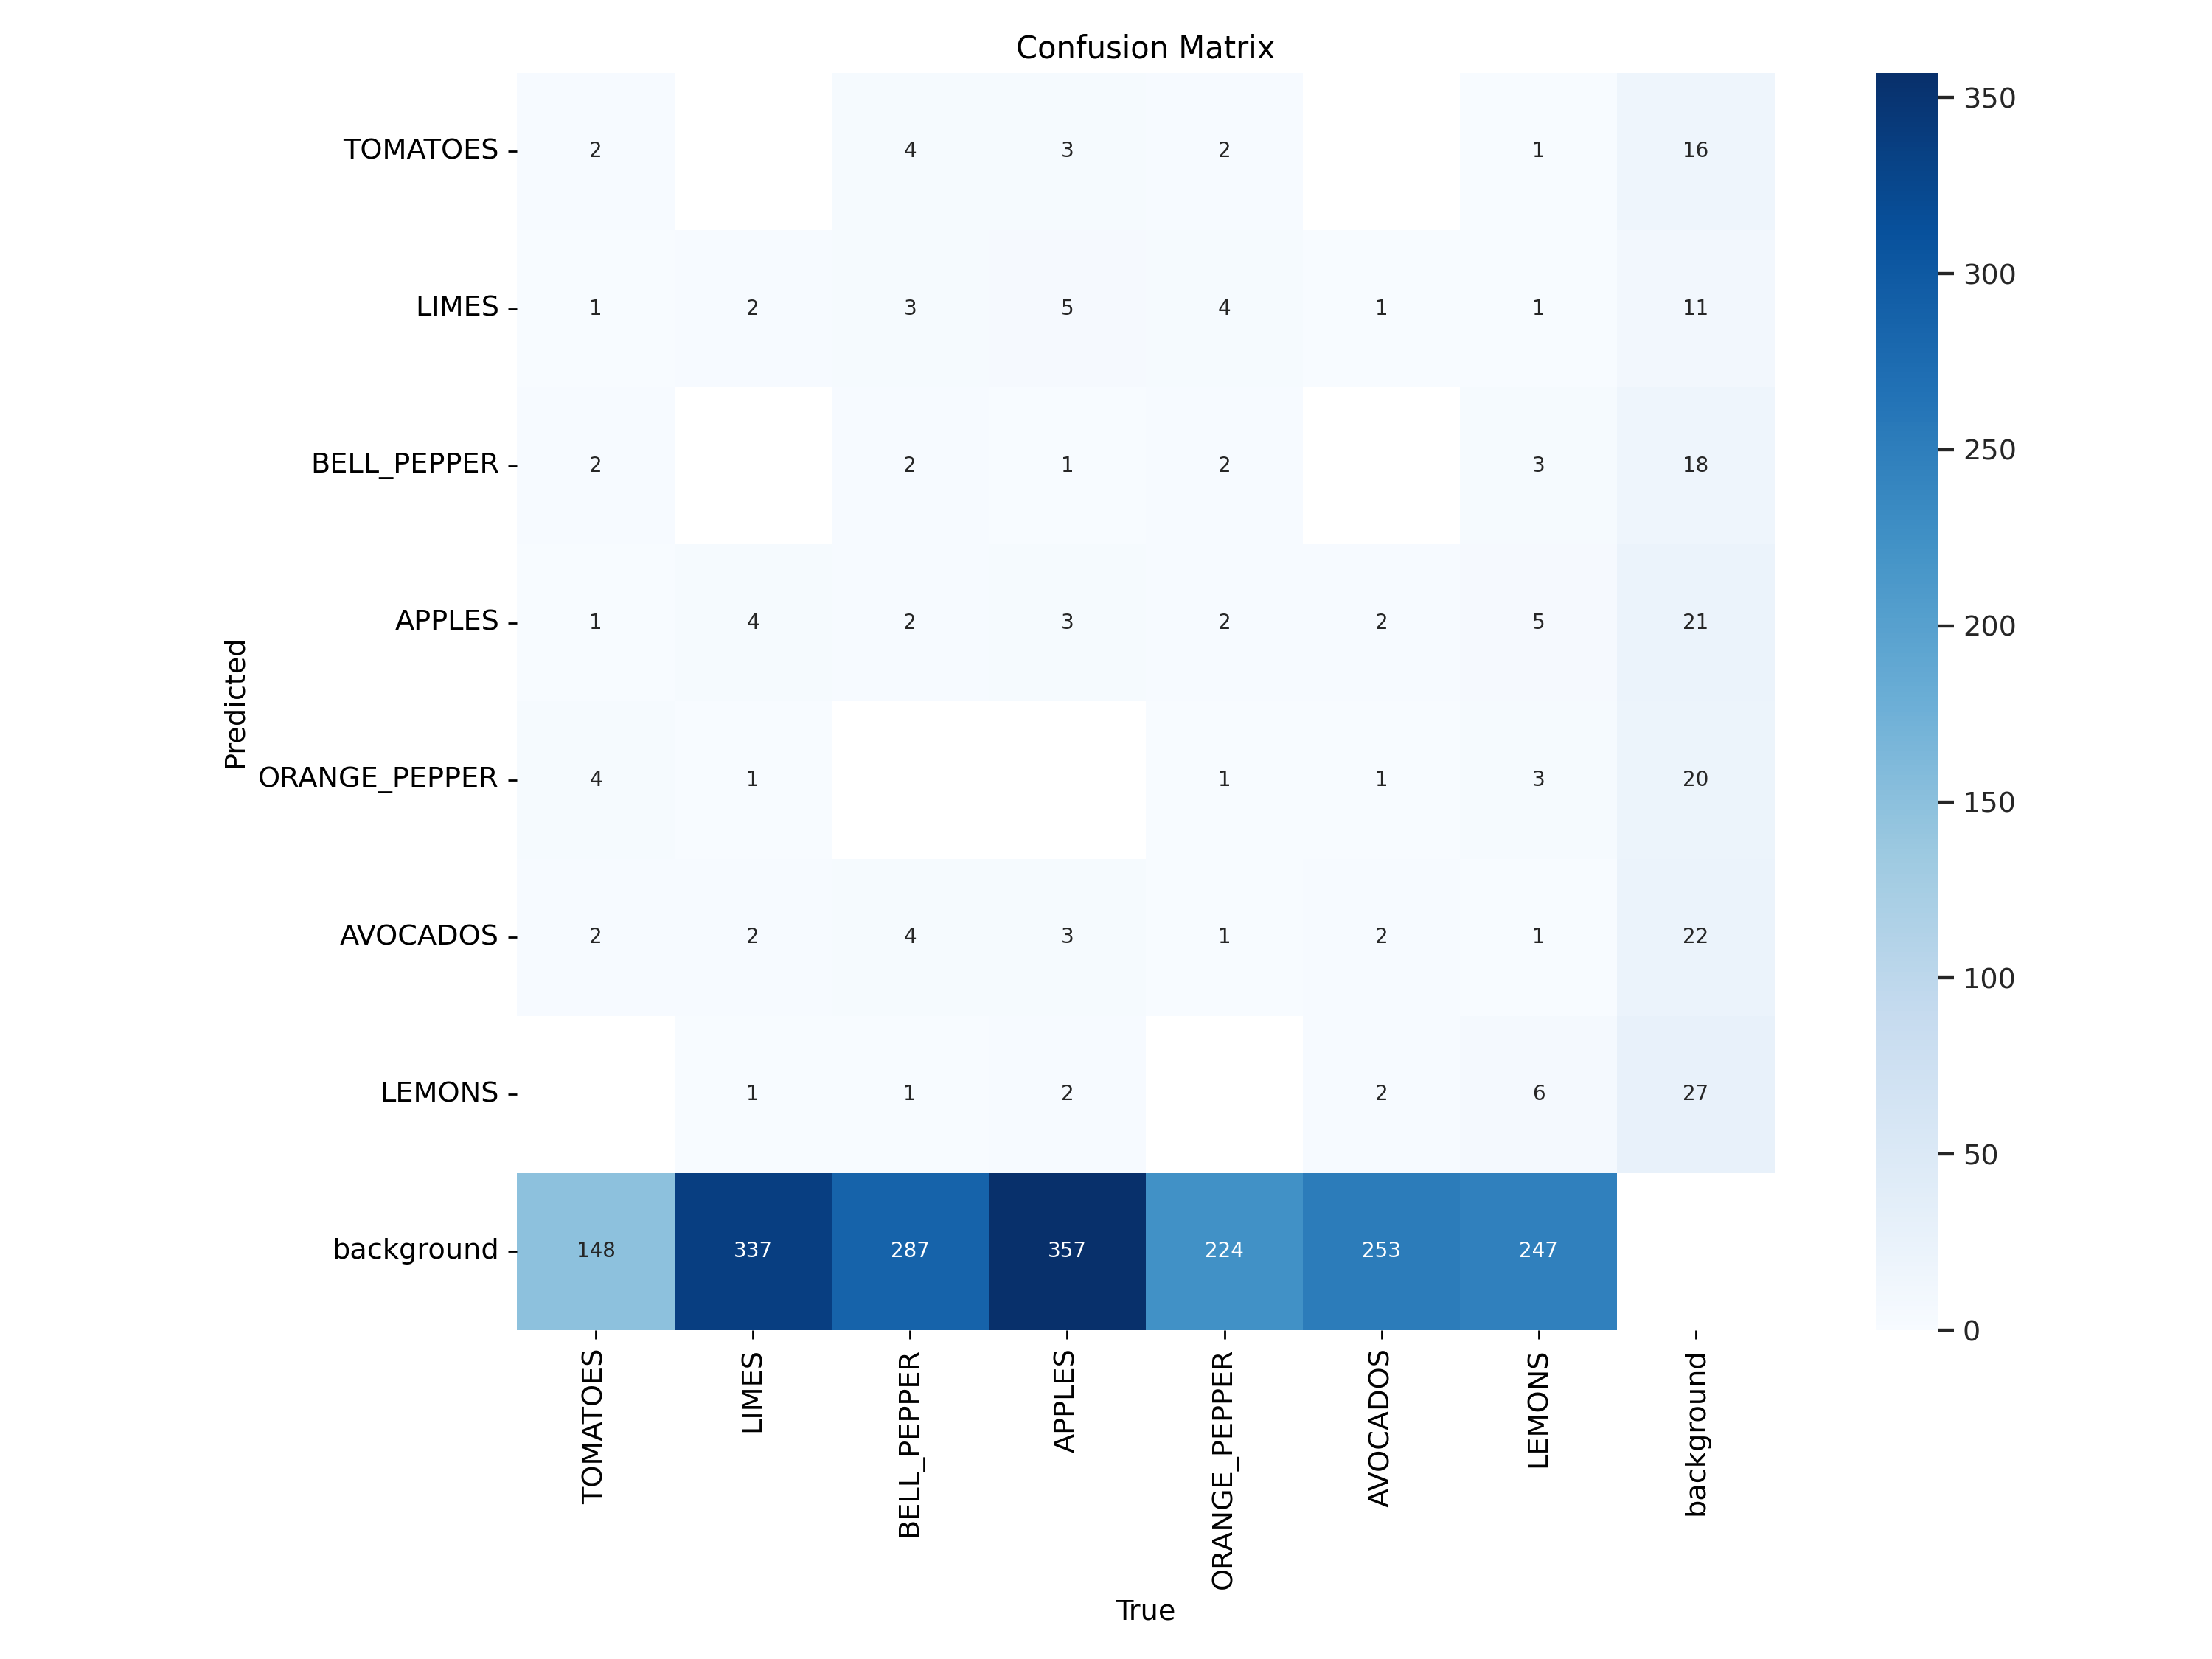

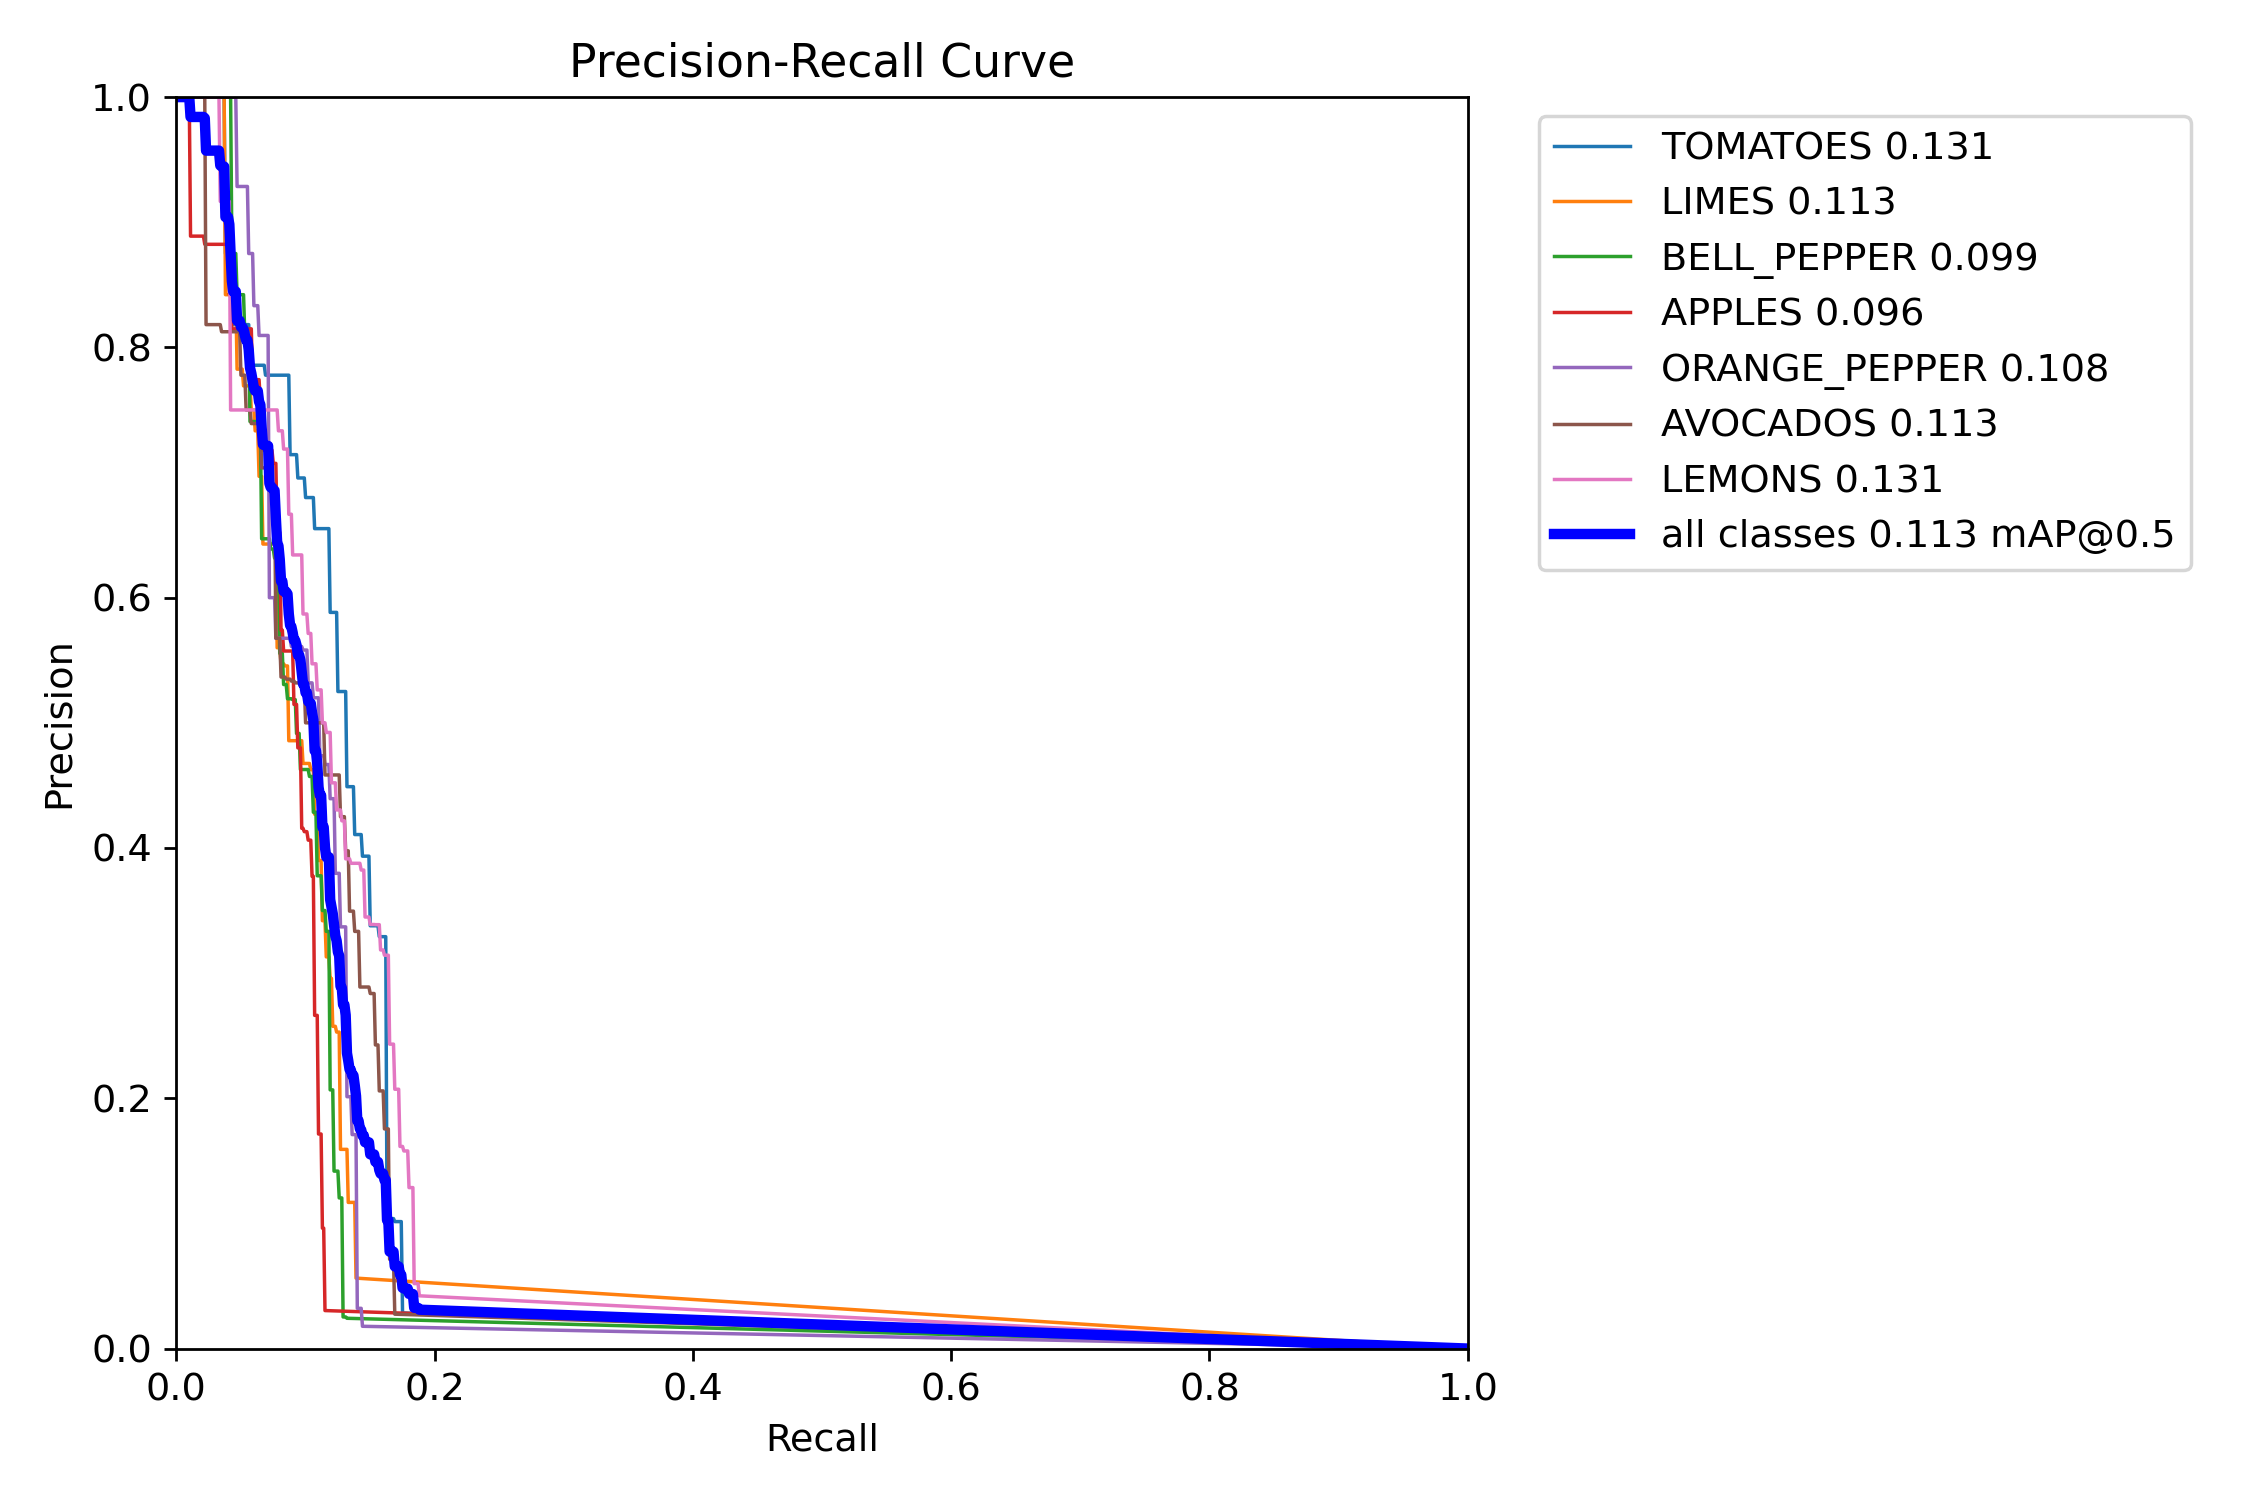

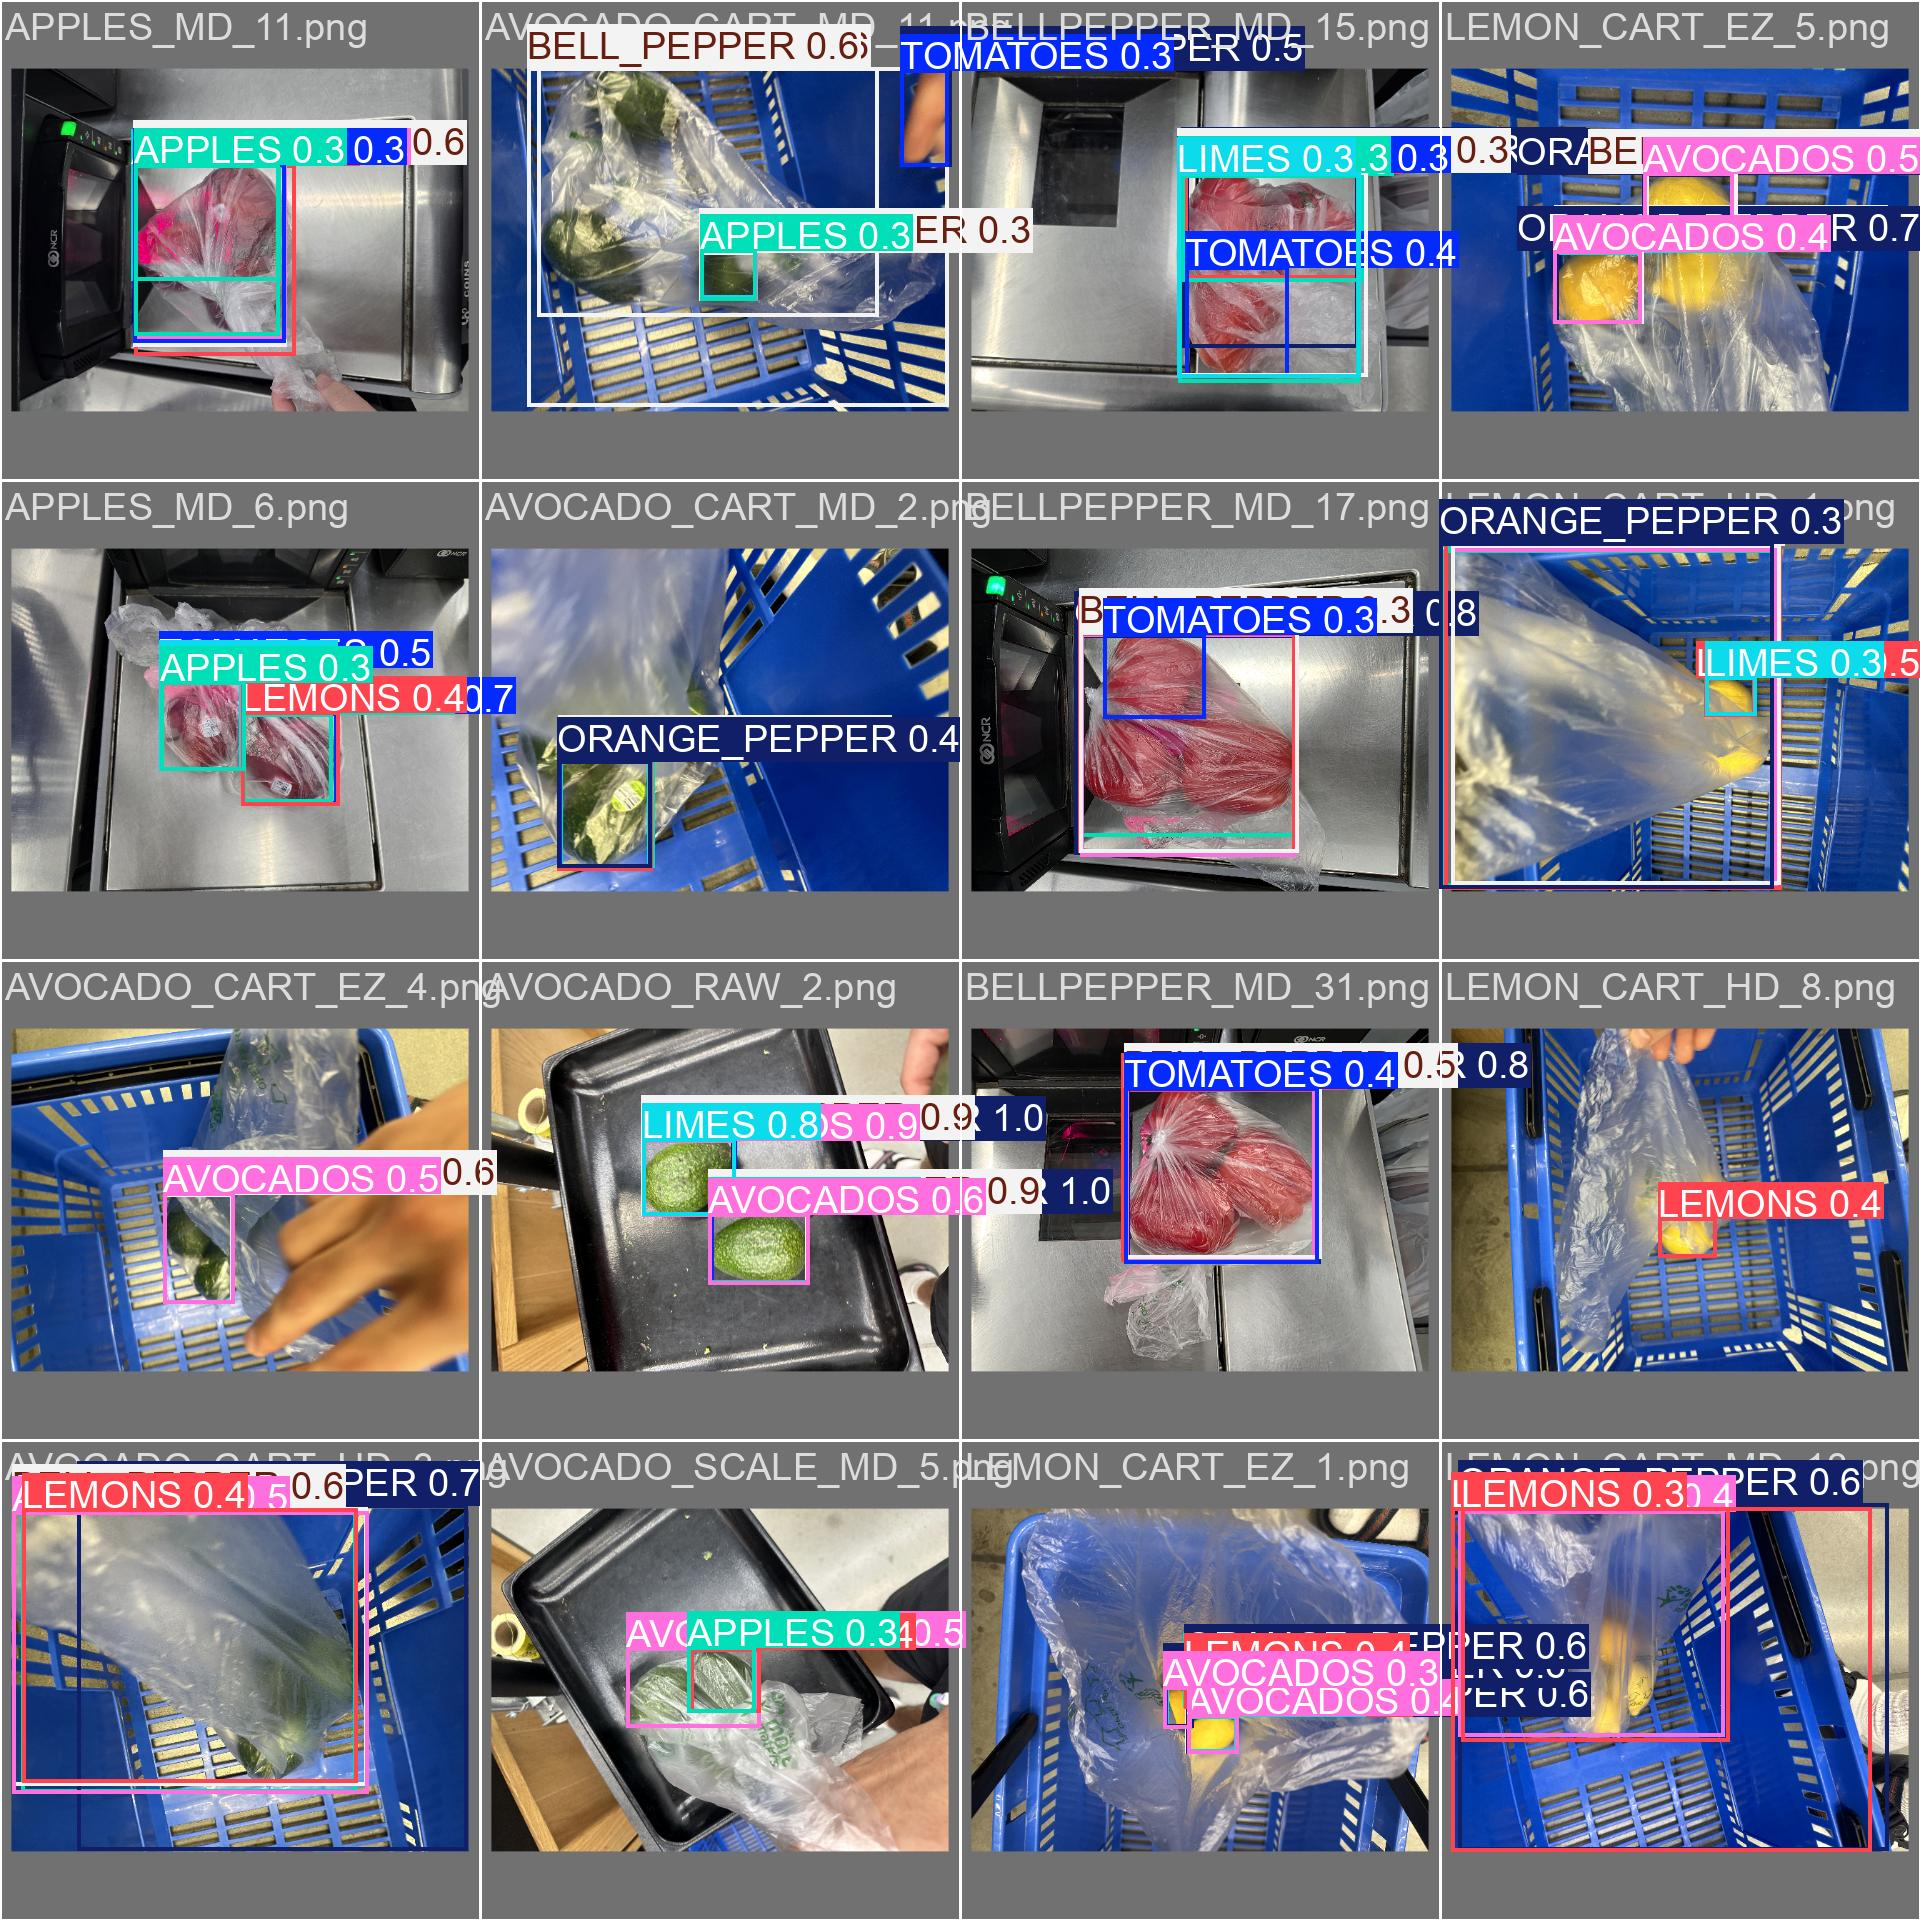

In [ ]:
from IPython.display import Image, display
import os

train_run_dir = "/content/runs/detect/autolabeled_yolov8n_train"

confusion_matrix_path = os.path.join(train_run_dir, "confusion_matrix.png")
display(Image(filename=confusion_matrix_path, width=600))

pr_curve_path = os.path.join(train_run_dir, "PR_curve.png")
display(Image(filename=pr_curve_path, width=600))

val_pred_path = os.path.join(train_run_dir, "val_batch0_pred.jpg")

display(Image(filename=val_pred_path))

In [ ]:
# Load best weights
model_weights = "/content/runs/detect/autolabeled_yolov8n_train/weights/best.pt"

# Test images
test_images = "/content/autolabeled_split_dataset/images/test"

# Evaluate on test images
!yolo predict \
  model="{model_weights}" \
  source="{test_images}" \
  save=True \
  device=0 \
  name="autolabeled_yolov8n_test_predictions"
  # conf=0.4 # Conf threshold


Ultralytics 8.3.108 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,008,378 parameters, 0 gradients, 8.1 GFLOPs

image 1/650 /content/kvnpatel_yolov8/images/test/0_0_apple_wb_7.jpg: 640x480 1 apple-bag, 68.9ms
image 2/650 /content/kvnpatel_yolov8/images/test/0_4_apple_wb_7.jpg: 640x480 1 apple-bag, 7.8ms
image 3/650 /content/kvnpatel_yolov8/images/test/100_6_grapes_wob_7.jpg: 640x480 2 grapess, 7.6ms
image 4/650 /content/kvnpatel_yolov8/images/test/101_4_grapes_wob_49.jpg: 640x480 2 grapess, 7.5ms
image 5/650 /content/kvnpatel_yolov8/images/test/102_2_grapes_wb_48.jpg: 640x480 1 grapes-bag, 7.5ms
image 6/650 /content/kvnpatel_yolov8/images/test/103_0_lemon_wb_14.jpg: 640x480 1 lemon-bag, 7.5ms
image 7/650 /content/kvnpatel_yolov8/images/test/104_3_lemon_wb_28.jpg: 480x640 1 lemon-bag, 53.3ms
image 8/650 /content/kvnpatel_yolov8/images/test/105_1_tomato_wb_49.jpg: 640x480 1 tomato-bag, 8.1ms
image 9/650 /content/kvnpatel_yolov8/images/

In [ ]:
!zip -r runs.zip /content/runs
#!zip -r veg_dataset.zip /content/veg_dataset

from google.colab import files
files.download('runs.zip')
#files.download('veg_dataset.zip')

  adding: content/runs/ (stored 0%)
  adding: content/runs/detect/ (stored 0%)
  adding: content/runs/detect/kvnpatel_yolov8n_train1/ (stored 0%)
  adding: content/runs/detect/kvnpatel_yolov8n_train1/val_batch0_labels.jpg (deflated 13%)
  adding: content/runs/detect/kvnpatel_yolov8n_train1/F1_curve.png (deflated 11%)
  adding: content/runs/detect/kvnpatel_yolov8n_train1/events.out.tfevents.1744696754.705849ba1a6e.4764.0 (deflated 88%)
  adding: content/runs/detect/kvnpatel_yolov8n_train1/train_batch3250.jpg (deflated 12%)
  adding: content/runs/detect/kvnpatel_yolov8n_train1/val_batch2_labels.jpg (deflated 7%)
  adding: content/runs/detect/kvnpatel_yolov8n_train1/train_batch0.jpg (deflated 4%)
  adding: content/runs/detect/kvnpatel_yolov8n_train1/train_batch1.jpg (deflated 3%)
  adding: content/runs/detect/kvnpatel_yolov8n_train1/confusion_matrix_normalized.png (deflated 20%)
  adding: content/runs/detect/kvnpatel_yolov8n_train1/val_batch0_pred.jpg (deflated 12%)
  adding: content/runs

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>